In [4]:
import time
import numpy as np
import matplotlib.pyplot as plt
import corner
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_probability as tfp

tfk = tf.keras
tfd = tfp.distributions
tfb = tfp.bijectors

seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

In [8]:
def timer(func):
    
    t0 = time.time()
    x = func()
    print(time.time() - t0)
    
    return x

In [2]:
dims = 2

In [33]:
distribution = tfd.Sample(
    tfd.Normal(loc=0., scale=1.),
    sample_shape=[dims],
    )

bijector = tfb.MaskedAutoregressiveFlow(
    tfb.AutoregressiveNetwork(
        params=2,
        hidden_units=[512, 512],
        ),
    )

In [34]:
maf = tfd.TransformedDistribution(
    distribution=distribution,
    bijector=bijector,
    )

In [35]:
sample = timer(lambda: maf.sample(10000))
lp = timer(lambda: maf.log_prob(sample))

0.1560063362121582
0.05186295509338379


In [37]:
iaf = tfd.TransformedDistribution(
    distribution=distribution,
    bijector=tfb.Invert(bijector),
    )

In [38]:
sample = timer(lambda: iaf.sample(10000))
lp = timer(lambda: maf.log_prob(sample))

0.06124138832092285
0.12322020530700684


In [41]:
distribution = tfd.Sample(
    tfd.Normal(loc=0., scale=1.),
    sample_shape=[dims],
    )

bijectors = []
for _ in range(2):
    made = tfb.AutoregressiveNetwork(params=2, hidden_units=[1024])
    bijector = tfb.MaskedAutoregressiveFlow(made)
    bijectors.append(bijector)
bijector = tfb.Chain(bijectors)

maf = tfd.TransformedDistribution(distribution=distribution, bijector=bijector)
iaf = tfd.TransformedDistribution(distribution=distribution, bijector=tfb.Invert(bijector))

0.18064284324645996
0.0807797908782959


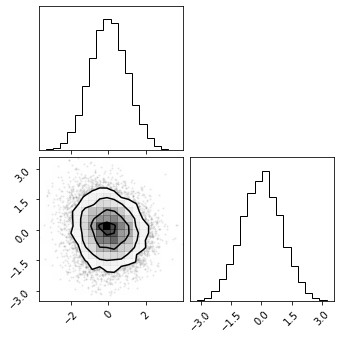

0.07560896873474121
0.07808542251586914


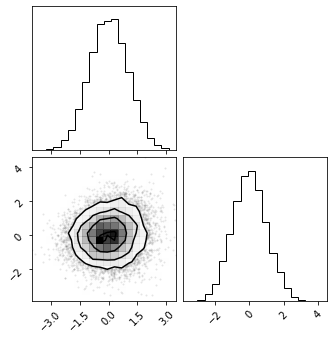

In [49]:
sample = timer(lambda: maf.sample(10000))
lp = timer(lambda: maf.log_prob(sample))
corner.corner(sample.numpy())
plt.show()

sample = timer(lambda: iaf.sample(10000))
lp = timer(lambda: iaf.log_prob(sample))
corner.corner(sample.numpy())
plt.show()

In [50]:
# https://github.com/tensorflow/probability/issues/1410
# https://github.com/tensorflow/probability/issues/1006#issuecomment-663141106

def make_kwargs(flow, condition):
    
    prefix = flow.bijector.bijectors[-1].name[:-1]
    
    return {
        b.name: {'conditional_input': condition}
        for b in flow.bijector.bijectors if prefix in b.name
        }

In [51]:
dims = 2
cond_dims = 1

In [52]:
distribution = tfd.Sample(
    tfd.Normal(loc=0., scale=1.),
    sample_shape=[dims],
    )

bijectors = []
for _ in range(10):
    made = tfb.AutoregressiveNetwork(
        params=2,
        event_shape=(dims,),
        conditional=True,
        conditional_event_shape=(cond_dims,),
        hidden_units=[1024],
        )
    bijector = tfb.MaskedAutoregressiveFlow(made, name=f'maf{_}')
    bijectors.append(bijector)
bijector = tfb.Chain(bijectors)

maf = tfd.TransformedDistribution(distribution=distribution, bijector=bijector)
iaf = tfd.TransformedDistribution(distribution=distribution, bijector=tfb.Invert(bijector))

0.254302978515625
0.1146700382232666


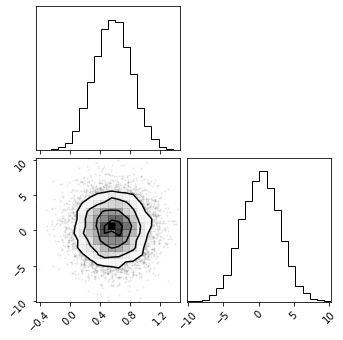

0.12899327278137207
0.10659384727478027


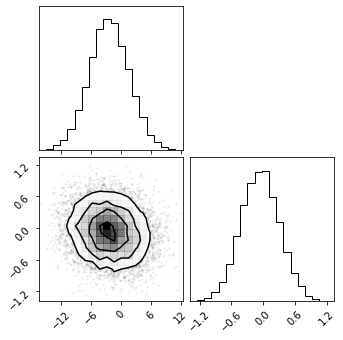

In [63]:
kw = make_kwargs(maf, [1.])

sample = timer(lambda: maf.sample(10000, bijector_kwargs=kw))
lp = timer(lambda: maf.log_prob(sample, bijector_kwargs=kw))
corner.corner(sample.numpy())
plt.show()

sample = timer(lambda: iaf.sample(10000, bijector_kwargs=kw))
lp = timer(lambda: iaf.log_prob(sample, bijector_kwargs=kw))
corner.corner(sample.numpy())
plt.show()